In [ ]:
! pip install -q langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

In [ ]:
%pip install -U langchain-text-splitters


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [ ]:
%pip install -U langchain-hub


In [ ]:
%pip install -U langchain langchain-community langchain-openai chromadb tiktoken


In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]=""
os.environ["LANGCHAIN_PROJECT"]="AgenticAI"
os.environ["OPENAI_API_KEY"] = ""
os.environ["TAVILY_API_KEY"] = ""



In [ ]:
import langchain
print(langchain.__version__)


1.2.0


In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma1",
    embedding=OpenAIEmbeddings(model="text-embedding-3-small"),
)

retriever = vectorstore.as_retriever()


In [ ]:
# Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal
from langchain_openai import ChatOpenAI

# pydantic data model

class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description="Documents are relevant to the question, 'yes' or 'no'"
  )

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory"

docs = retriever.invoke(question)

doc_txt = docs[0].page_content

print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


binary_score='yes'


In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant. Answer using only the context. If not in context, say you don't know."),
    ("human", "Context:\n{context}\n\nQuestion:\n{question}")
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def format_docs(docs):
    return "\n\n".join(d.page_content for d in docs)

rag_chain = prompt | llm | StrOutputParser()

generation = rag_chain.invoke({
    "context": format_docs(docs),
    "question": question
})

print(generation)


Agent memory refers to a long-term memory module (external database) that records a comprehensive list of the agents' experiences in natural language. This memory allows agents to behave conditioned on past experiences and interact with other agents effectively.


In [ ]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is agent memory and how does it function in artificial intelligence?'

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [ ]:
# create the graph

from typing import TypedDict, List

class GraphState(TypedDict):
  question: str
  documents: List[str]
  generation: str
  web_search: str


In [ ]:
def retrieve(state: GraphState) -> GraphState:
    print("------RETRIEVE-------")
    question = state["question"]
    documents = retriever.invoke(question)  # ✅ updated API
    return {"question": question, "documents": documents}


In [ ]:
def generate(state:GraphState) -> GraphState:
  print("--------GENERATE---------")
  question = state["question"]
  documents = state["documents"]

  generation = rag_chain.invoke({"question": question, "context": documents})
  return {"question": question, "documents": documents, "generation": generation}


In [ ]:
def grade_documents(state:GraphState) -> GraphState:
  print("----- Grading the Documents --------")
  question = state["question"]
  documents = state["documents"]

  # score each doc

  filtered_docs = []
  web_search = "No"

  for d in documents:
    score = retrieval_grader.invoke({"question": question, "document": d.page_content})
    grade = score.binary_score

    if grade == "yes":
      print("---- Grade: Document Relevant")
      filtered_docs.append(d)
    else:
      print("---- Grade: Document Not Relevant")
      web_search = "Yes"
      continue
  return {"question": question, "documents": filtered_docs, "web_search": web_search}









In [ ]:
from langchain_core.documents import Document

def web_search(state: GraphState) -> GraphState:
    print("----- web search --------")
    question = state["question"]
    documents = state["documents"]

    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])

    web_doc = Document(page_content=web_results)
    documents.append(web_doc)

    return {"question": question, "documents": documents}


In [ ]:
def transform_query(state:GraphState) -> GraphState:
  print("-------- Tranform Query --------")
  question = state["question"]
  documents = state["documents"]

  better_question = question_rewriter.invoke({"question": question})
  return {"question": better_question, "documents": documents}


In [ ]:
def decide_to_generate(state:GraphState):
  print("-------- assess graded documents--------")
  web_search = state["web_search"]

  if web_search == "Yes":
    print("----- all documents are not relevant to the question, so transform query-----")
    return "transform_query"
  else:
    print("----- all documents are relevant to the question, so generate -----")
    return "generate"


In [ ]:
from langgraph.graph import START, END, StateGraph

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()

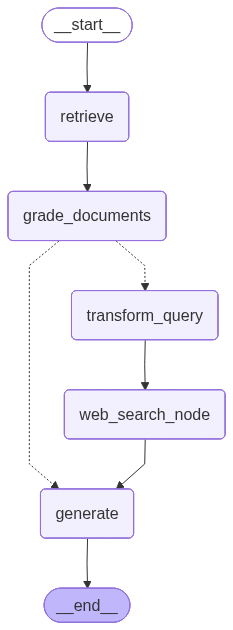

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value["generation"])





------RETRIEVE-------
"Node 'retrieve':"
'\n---\n'
----- Grading the Documents --------
---- Grade: Document Relevant
---- Grade: Document Relevant
---- Grade: Document Not Relevant
---- Grade: Document Not Relevant
-------- assess graded documents--------
----- all documents are not relevant to the question, so transform query-----
"Node 'grade_documents':"
'\n---\n'
-------- Tranform Query --------
"Node 'transform_query':"
'\n---\n'
----- web search --------
"Node 'web_search_node':"
'\n---\n'
--------GENERATE---------
"Node 'generate':"
'\n---\n'
('The different types of agent memory in artificial intelligence include:\n'
 '\n'
 '1. **Short-term memory**: Holds immediate context within a single '
 'interaction and helps maintain coherence in the moment.\n'
 '   - Example: Working Memory, which maintains short-term conversational '
 'coherence.\n'
 '\n'
 '2. **Long-term memory**: Persists knowledge across sessions, tasks, and '
 'time, allowing the agent to learn, personalize, and a

In [ ]:
from pprint import pprint

# Run
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value["documents"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

------RETRIEVE-------
"Node 'retrieve':"
[ Document(metadata={'description': 'The use of large language models in the real world has strongly accelerated by the launch of ChatGPT. We (including my team at OpenAI, shoutout to them) have invested a lot of effort to build default safe behavior into the model during the alignment process (e.g. via RLHF). However, adversarial attacks or jailbreak prompts could potentially trigger the model to output something undesired.\nA large body of ground work on adversarial attacks is on images, and differently it operates in the continuous, high-dimensional space. Attacks for discrete data like text have been considered to be a lot more challenging, due to lack of direct gradient signals. My past post on Controllable Text Generation is quite relevant to this topic, as attacking LLMs is essentially to control the model to output a certain type of (unsafe) content.', 'title': "Adversarial Attacks on LLMs | Lil'Log", 'language': 'en', 'source': 'https:/